## 加载、预处理、增强以及批量处理

1. **加载数据集**：我们利用TensorFlow数据集库（tensorflow_datasets）加载了“猫vs狗”的数据集。数据集被划分为训练集和验证集，其中训练集占据了整体数据的80%，验证集则占据了剩余的20%。

2. **设定图像尺寸**：设定了图像的尺寸（IMG_SIZE）为160。这是一个预设的值，根据实际需求进行调整。

3. **预处理函数**：定义了一个预处理函数。该函数将图像的数据类型转换为float32，将图像的像素值归一化到0到1的范围内，并将图像的大小调整为预设的尺寸（160x160）。

4. **数据增强函数**：定义了一个数据增强函数。该函数通过随机左右翻转图像、调整图像的亮度、对比度以及饱和度等方式，增加了训练数据的多样性，有助于提高模型的泛化能力。

5. **应用预处理和数据增强**：将预处理函数应用到训练集和验证集上，同时仅将数据增强函数应用到训练集上。

6. **优化训练速度**：对训练集进行了混洗（shuffle），分批（batch）和预加载（prefetch）以优化训练速度。对验证集也进行了分批和预加载。

至此，训练集（ds_train）和验证集（ds_validation）已经准备好，可以直接用于模型的训练和验证了。

In [9]:
import tensorflow as tf
import tensorflow_datasets as tfds

# Load the dataset
(ds_train, ds_validation), ds_info = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:]'],
    as_supervised=True,
    with_info=True,
)

# Define the size to which you want to resize the images
IMG_SIZE = 160

# Define the preprocessing function
def preprocess(image, label):
    image = tf.cast(image, tf.float32)
    image = (image / 255.0)
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    return image, label

# Define the augmentation function
def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    image = tf.image.random_saturation(image, lower=0.8, upper=1.2)
    # Add more transformations as needed
    return image, label

# Apply the preprocess function to both training and validation datasets
ds_train = ds_train.map(preprocess)
ds_validation = ds_validation.map(preprocess)

# Apply the augmentation only to the training dataset
ds_train = ds_train.map(augment)

# Shuffle, batch, and prefetch the training dataset for optimal training speed
BUFFER_SIZE = 1000
BATCH_SIZE = 16

ds_train = ds_train.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
ds_validation = ds_validation.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Now, ds_train and ds_validation are ready to be used in a model

## 图像二分类任务的卷积神经网络（Convolutional Neural Network, CNN）模型

1. **模型构建**：我们使用了Keras的Sequential API构建模型，这是一种简单且易于理解的模型定义方式，允许我们将一系列网络层线性堆叠起来。

2. **第一层 - 卷积层**：模型的第一层是一个卷积层（Conv2D），其使用32个3x3的卷积核，并采用ReLU（Rectified Linear Unit）作为激活函数。这一层的输入形状被设定为160x160x3，这对应于我们之前预处理后的图像尺寸和颜色通道数（RGB）。

3. **第二层 - 池化层**：接下来是一个最大池化层（MaxPooling2D），池化窗口的大小为2x2。池化层可以降低特征的空间维度，从而减少计算量并提高模型的泛化能力。

4. **接下来的几层**：然后，我们又添加了两个卷积层和最大池化层的组合，其中卷积层的卷积核数量分别为64和128。

5. **Dropout层**：接着，我们添加了一个Dropout层，其丢弃率为0.5。Dropout是一种正则化技术，可以防止模型过拟合。

6. **展平层**：之后，我们添加了一个展平层（Flatten），用于将多维的卷积特征图展平为一维，以便输入到后面的全连接层。

7. **全连接层**：最后，我们添加了两个全连接层（Dense）。第一个全连接层有512个神经元，使用ReLU作为激活函数。第二个全连接层有1个神经元，使用sigmoid作为激活函数，用于输出图像属于“狗”类别的概率。

8. **模型编译**：在模型的编译（compile）阶段，我们为模型设置了损失函数、优化器和评估指标。损失函数选择了二元交叉熵（binary_crossentropy），这是二分类问题的常用损失函数。优化器选择了学习率为0.0001的RMSprop优化器。评估指标选择了准确率（accuracy）。

In [10]:
from keras.src.optimizers import RMSprop

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(160, 160, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.5), 
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(
    loss='binary_crossentropy',
    optimizer=RMSprop(lr=1e-4),
    metrics=['acc']
)

## 模型训练：

使用`model.fit`函数进行模型的训练，其中：

   - `ds_train`：训练数据集。
   - `steps_per_epoch`：每个训练周期（epoch）的步数，设定为20步。
   - `epochs`：训练周期的数量，设定为50个周期。一般来说，训练周期的数量可以根据训练的速度进行调整，建议的范围是10到50个周期，如果训练速度快，可以设定更多的训练周期。
   - `validation_data`：验证数据集，设定为`ds_validation`。
   - `validation_steps`：每个验证周期的步数，设定为10步。
   - `verbose`：训练过程的详细信息展示模式，设定为1表示展示所有信息。

此段代码将模型在训练数据集上进行训练，并在每个训练周期结束后在验证数据集上进行验证，以监控模型在未见过的数据上的性能。这有助于我们观察模型是否出现过拟合，并可以根据验证结果调整模型的参数和优化器的学习率。

In [11]:
history = model.fit(
    ds_train,  # Training dataset
    steps_per_epoch=20,  # Number of steps to run per epoch
    epochs=50,  # Number of training epochs, suggested range is [10, 50] or more if the training is fast
    validation_data=ds_validation,  # Validation dataset
    validation_steps=10,  # Number of steps to run for validation
    verbose=1
)

Epoch 1/50


2023-12-01 18:24:03.905428: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_2/dropout_2/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


20/20 [==============================] - 2s 47ms/step - loss: 0.7962 - acc: 0.4906 - val_loss: 0.6938 - val_acc: 0.4375
Epoch 2/50
 3/20 [===>..........................] - ETA: 0s - loss: 0.6841 - acc: 0.5625

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


20/20 [==============================] - 1s 41ms/step - loss: 0.6959 - acc: 0.5281 - val_loss: 0.6784 - val_acc: 0.5688
Epoch 3/50
 3/20 [===>..........................] - ETA: 0s - loss: 0.7143 - acc: 0.5417

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


20/20 [==============================] - 1s 40ms/step - loss: 0.6900 - acc: 0.5500 - val_loss: 0.6743 - val_acc: 0.5875
Epoch 4/50
 5/20 [======>.......................] - ETA: 0s - loss: 0.6916 - acc: 0.5500

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


20/20 [==============================] - 1s 41ms/step - loss: 0.6839 - acc: 0.5437 - val_loss: 0.6845 - val_acc: 0.5250
Epoch 5/50
 5/20 [======>.......................] - ETA: 0s - loss: 0.6739 - acc: 0.5625

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


20/20 [==============================] - 1s 41ms/step - loss: 0.6633 - acc: 0.5688 - val_loss: 0.8634 - val_acc: 0.4313
Epoch 6/50
 3/20 [===>..........................] - ETA: 0s - loss: 0.7012 - acc: 0.5833

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


20/20 [==============================] - 1s 41ms/step - loss: 0.6852 - acc: 0.5344 - val_loss: 0.6782 - val_acc: 0.5562
Epoch 7/50
 3/20 [===>..........................] - ETA: 0s - loss: 0.6678 - acc: 0.5833

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


20/20 [==============================] - 1s 41ms/step - loss: 0.6792 - acc: 0.5781 - val_loss: 0.7472 - val_acc: 0.4375
Epoch 8/50
 3/20 [===>..........................] - ETA: 0s - loss: 0.6543 - acc: 0.6250

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


20/20 [==============================] - 1s 40ms/step - loss: 0.6789 - acc: 0.6125 - val_loss: 0.6638 - val_acc: 0.5813
Epoch 9/50
 5/20 [======>.......................] - ETA: 0s - loss: 0.6112 - acc: 0.7250

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


20/20 [==============================] - 1s 41ms/step - loss: 0.6452 - acc: 0.6375 - val_loss: 0.6326 - val_acc: 0.6500
Epoch 10/50
 3/20 [===>..........................] - ETA: 0s - loss: 0.6422 - acc: 0.6250

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


20/20 [==============================] - 1s 40ms/step - loss: 0.6502 - acc: 0.5969 - val_loss: 0.6718 - val_acc: 0.5750
Epoch 11/50
 5/20 [======>.......................] - ETA: 0s - loss: 0.6190 - acc: 0.6375

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


20/20 [==============================] - 1s 41ms/step - loss: 0.6531 - acc: 0.6031 - val_loss: 0.6110 - val_acc: 0.7125
Epoch 12/50
 3/20 [===>..........................] - ETA: 0s - loss: 0.6797 - acc: 0.6042

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


20/20 [==============================] - 1s 41ms/step - loss: 0.6575 - acc: 0.6438 - val_loss: 0.6040 - val_acc: 0.6938
Epoch 13/50
 3/20 [===>..........................] - ETA: 0s - loss: 0.6010 - acc: 0.6667

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


20/20 [==============================] - 1s 41ms/step - loss: 0.6137 - acc: 0.6687 - val_loss: 0.6012 - val_acc: 0.7000
Epoch 14/50
 3/20 [===>..........................] - ETA: 0s - loss: 0.6161 - acc: 0.7083

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


20/20 [==============================] - 1s 41ms/step - loss: 0.6419 - acc: 0.6500 - val_loss: 0.6004 - val_acc: 0.7063
Epoch 15/50
 3/20 [===>..........................] - ETA: 0s - loss: 0.6737 - acc: 0.5625

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


20/20 [==============================] - 1s 43ms/step - loss: 0.6359 - acc: 0.6469 - val_loss: 0.5849 - val_acc: 0.6938
Epoch 16/50
 3/20 [===>..........................] - ETA: 0s - loss: 0.6215 - acc: 0.6250

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


20/20 [==============================] - 1s 42ms/step - loss: 0.6187 - acc: 0.6562 - val_loss: 0.5881 - val_acc: 0.7312
Epoch 17/50
 3/20 [===>..........................] - ETA: 0s - loss: 0.5660 - acc: 0.7500

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


15/20 [=====================>........] - ETA: 0s - loss: 0.6049 - acc: 0.6792

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


20/20 [==============================] - 1s 41ms/step - loss: 0.6103 - acc: 0.6687 - val_loss: 0.6149 - val_acc: 0.6625
Epoch 18/50
 3/20 [===>..........................] - ETA: 0s - loss: 0.5490 - acc: 0.7500

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


20/20 [==============================] - 1s 41ms/step - loss: 0.5957 - acc: 0.6594 - val_loss: 0.5923 - val_acc: 0.6750
Epoch 19/50
 3/20 [===>..........................] - ETA: 0s - loss: 0.7324 - acc: 0.5208

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


20/20 [==============================] - 1s 42ms/step - loss: 0.6390 - acc: 0.6375 - val_loss: 0.5818 - val_acc: 0.6938
Epoch 20/50
 3/20 [===>..........................] - ETA: 0s - loss: 0.5956 - acc: 0.6875

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


19/20 [===========================>..] - ETA: 0s - loss: 0.5923 - acc: 0.6974

20/20 [==============================] - 1s 41ms/step - loss: 0.5973 - acc: 0.6969 - val_loss: 0.5596 - val_acc: 0.6500
Epoch 21/50
 3/20 [===>..........................] - ETA: 0s - loss: 0.5630 - acc: 0.6042

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


19/20 [===========================>..] - ETA: 0s - loss: 0.5987 - acc: 0.6645

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


20/20 [==============================] - 1s 42ms/step - loss: 0.6090 - acc: 0.6531 - val_loss: 0.5586 - val_acc: 0.6875
Epoch 22/50
 3/20 [===>..........................] - ETA: 0s - loss: 0.6240 - acc: 0.6250

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


20/20 [==============================] - 1s 40ms/step - loss: 0.5917 - acc: 0.6750 - val_loss: 0.5480 - val_acc: 0.6875
Epoch 23/50
 3/20 [===>..........................] - ETA: 0s - loss: 0.5858 - acc: 0.7083

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


20/20 [==============================] - 1s 42ms/step - loss: 0.5780 - acc: 0.6938 - val_loss: 0.5274 - val_acc: 0.7563
Epoch 24/50
 3/20 [===>..........................] - ETA: 0s - loss: 0.6594 - acc: 0.6875

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


20/20 [==============================] - 1s 41ms/step - loss: 0.6078 - acc: 0.6469 - val_loss: 0.5153 - val_acc: 0.7625
Epoch 25/50
 3/20 [===>..........................] - ETA: 0s - loss: 0.5993 - acc: 0.6458

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


20/20 [==============================] - 1s 41ms/step - loss: 0.5675 - acc: 0.7094 - val_loss: 0.5156 - val_acc: 0.7750
Epoch 26/50
 3/20 [===>..........................] - ETA: 0s - loss: 0.5317 - acc: 0.7917

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


20/20 [==============================] - 1s 41ms/step - loss: 0.5516 - acc: 0.7375 - val_loss: 0.5986 - val_acc: 0.6438
Epoch 27/50
 3/20 [===>..........................] - ETA: 0s - loss: 0.4797 - acc: 0.6667

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


20/20 [==============================] - 1s 40ms/step - loss: 0.5832 - acc: 0.6750 - val_loss: 0.5256 - val_acc: 0.7688
Epoch 28/50
 5/20 [======>.......................] - ETA: 0s - loss: 0.5082 - acc: 0.7500

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


19/20 [===========================>..] - ETA: 0s - loss: 0.5673 - acc: 0.6875

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


20/20 [==============================] - 1s 41ms/step - loss: 0.5715 - acc: 0.6844 - val_loss: 0.5366 - val_acc: 0.7688
Epoch 29/50
20/20 [==============================] - 1s 40ms/step - loss: 0.5773 - acc: 0.6875 - val_loss: 0.5181 - val_acc: 0.7437
Epoch 30/50
 5/20 [======>.......................] - ETA: 0s - loss: 0.5029 - acc: 0.7000

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


20/20 [==============================] - 1s 41ms/step - loss: 0.5726 - acc: 0.7125 - val_loss: 0.5278 - val_acc: 0.7625
Epoch 31/50
 3/20 [===>..........................] - ETA: 0s - loss: 0.5457 - acc: 0.7500

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


20/20 [==============================] - 1s 46ms/step - loss: 0.6025 - acc: 0.7094 - val_loss: 0.4985 - val_acc: 0.8125
Epoch 32/50
 3/20 [===>..........................] - ETA: 0s - loss: 0.5181 - acc: 0.7083

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


20/20 [==============================] - 1s 42ms/step - loss: 0.5769 - acc: 0.7000 - val_loss: 0.5156 - val_acc: 0.8188
Epoch 33/50
 5/20 [======>.......................] - ETA: 0s - loss: 0.5434 - acc: 0.7125

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


20/20 [==============================] - 1s 41ms/step - loss: 0.5529 - acc: 0.7031 - val_loss: 0.5238 - val_acc: 0.7125
Epoch 34/50
 3/20 [===>..........................] - ETA: 0s - loss: 0.6615 - acc: 0.6250

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


20/20 [==============================] - 1s 41ms/step - loss: 0.5776 - acc: 0.6875 - val_loss: 0.5714 - val_acc: 0.6938
Epoch 35/50
 3/20 [===>..........................] - ETA: 0s - loss: 0.5753 - acc: 0.7292

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


20/20 [==============================] - 1s 41ms/step - loss: 0.5705 - acc: 0.7281 - val_loss: 0.5262 - val_acc: 0.7125
Epoch 36/50
 3/20 [===>..........................] - ETA: 0s - loss: 0.5596 - acc: 0.6667

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


20/20 [==============================] - 1s 41ms/step - loss: 0.5375 - acc: 0.7469 - val_loss: 0.5043 - val_acc: 0.7625
Epoch 37/50
 3/20 [===>..........................] - ETA: 0s - loss: 0.5858 - acc: 0.6667

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


20/20 [==============================] - 1s 41ms/step - loss: 0.5685 - acc: 0.6938 - val_loss: 0.4995 - val_acc: 0.7937
Epoch 38/50
 3/20 [===>..........................] - ETA: 0s - loss: 0.6263 - acc: 0.6458

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


20/20 [==============================] - 1s 40ms/step - loss: 0.5819 - acc: 0.7188 - val_loss: 0.5155 - val_acc: 0.7312
Epoch 39/50
 5/20 [======>.......................] - ETA: 0s - loss: 0.4996 - acc: 0.7375

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


20/20 [==============================] - 1s 41ms/step - loss: 0.5308 - acc: 0.7188 - val_loss: 0.4784 - val_acc: 0.7875
Epoch 40/50
 3/20 [===>..........................] - ETA: 0s - loss: 0.4523 - acc: 0.8125

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


20/20 [==============================] - 1s 41ms/step - loss: 0.5392 - acc: 0.7531 - val_loss: 0.4866 - val_acc: 0.7500
Epoch 41/50
 3/20 [===>..........................] - ETA: 0s - loss: 0.6678 - acc: 0.6458

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


20/20 [==============================] - 1s 41ms/step - loss: 0.5696 - acc: 0.6875 - val_loss: 0.5495 - val_acc: 0.7250
Epoch 42/50
 3/20 [===>..........................] - ETA: 0s - loss: 0.5771 - acc: 0.6667

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


20/20 [==============================] - 1s 45ms/step - loss: 0.5675 - acc: 0.6938 - val_loss: 0.5058 - val_acc: 0.7812
Epoch 43/50
 3/20 [===>..........................] - ETA: 0s - loss: 0.3984 - acc: 0.8750

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


20/20 [==============================] - 1s 41ms/step - loss: 0.5642 - acc: 0.7250 - val_loss: 0.5142 - val_acc: 0.7563
Epoch 44/50
 3/20 [===>..........................] - ETA: 0s - loss: 0.5730 - acc: 0.7292

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


20/20 [==============================] - 1s 41ms/step - loss: 0.5387 - acc: 0.7312 - val_loss: 0.4841 - val_acc: 0.7688
Epoch 45/50
 3/20 [===>..........................] - ETA: 0s - loss: 0.4023 - acc: 0.8333

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


20/20 [==============================] - 1s 40ms/step - loss: 0.4938 - acc: 0.7344 - val_loss: 0.4683 - val_acc: 0.8062
Epoch 46/50
 5/20 [======>.......................] - ETA: 0s - loss: 0.5771 - acc: 0.7375

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


20/20 [==============================] - 1s 41ms/step - loss: 0.5644 - acc: 0.7437 - val_loss: 0.5528 - val_acc: 0.7063
Epoch 47/50
 3/20 [===>..........................] - ETA: 0s - loss: 0.5264 - acc: 0.7083

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


20/20 [==============================] - 1s 41ms/step - loss: 0.5754 - acc: 0.7063 - val_loss: 0.4680 - val_acc: 0.8062
Epoch 48/50
 3/20 [===>..........................] - ETA: 0s - loss: 0.5996 - acc: 0.7083

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


20/20 [==============================] - 1s 41ms/step - loss: 0.5865 - acc: 0.6844 - val_loss: 0.4818 - val_acc: 0.7937
Epoch 49/50
 3/20 [===>..........................] - ETA: 0s - loss: 0.5711 - acc: 0.7083

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


19/20 [===========================>..] - ETA: 0s - loss: 0.5440 - acc: 0.7105

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


20/20 [==============================] - 1s 41ms/step - loss: 0.5621 - acc: 0.7031 - val_loss: 0.4772 - val_acc: 0.8000
Epoch 50/50
 3/20 [===>..........................] - ETA: 0s - loss: 0.5122 - acc: 0.7500

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


20/20 [==============================] - 1s 41ms/step - loss: 0.5286 - acc: 0.7437 - val_loss: 0.4830 - val_acc: 0.7812


Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


## 保存模型和绘制训练和验证过程中的精度和损失曲线

1. **保存模型**：使用`model.save`函数将训练好的模型保存为'H5'格式的文件，文件名为'model.h5'。

2. **获取精度和损失值**：从`history.history`中获取训练和验证过程中的精度和损失值。其中：

   - `acc`：训练精度。
   - `val_acc`：验证精度。
   - `loss`：训练损失。
   - `val_loss`：验证损失。
   - `epochs`：训练周期数，通过获取精度列表的长度得到。

3. **绘制精度曲线**：使用`matplotlib.pyplot`的`plot`函数绘制训练和验证精度随训练周期变化的曲线。`title`函数用于设置图表的标题，`legend`函数用于设置图例。

4. **绘制损失曲线**：同样使用`matplotlib.pyplot`的`plot`函数绘制训练和验证损失随训练周期变化的曲线。`title`函数用于设置图表的标题，`legend`函数用于设置图例。

5. **显示图表**：使用`show`函数显示图表。

此段代码可以帮助我们更直观地观察模型在训练和验证过程中精度和损失的变化情况，从而更好地理解模型的学习情况，如是否出现过拟合或欠拟合等问题。

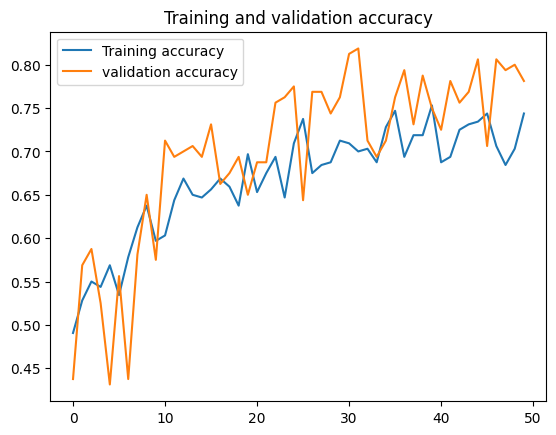

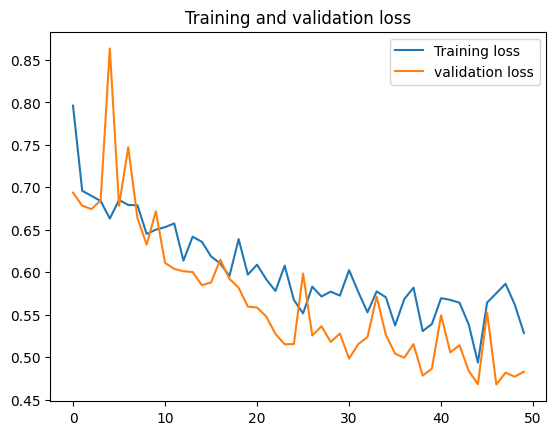

In [12]:
from matplotlib import pyplot as plt

model.save('model.h5')
# 得到精度和损失值
acc = history.history['acc'] # train_acc
val_acc = history.history['val_acc'] # val_acc
loss = history.history['loss'] # train_loss
val_loss = history.history['val_loss'] # val_loss
epochs = range(len(acc)) # 得到迭代次数
# 绘制精度曲线
plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Training and validation accuracy')
plt.legend(('Training accuracy', 'validation accuracy'))
plt.figure()
# 绘制损失曲线
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.legend(('Training loss', 'validation loss'))
plt.title('Training and validation loss')
plt.show()

## 总结

您只提供了50张照片，这远远不足以训练一个准确率超过随机猜测的模型。我使用了TensorFlow数据集来获取一些高质量的带分类的猫和狗的图片。

### 预测准确率曲线的结果

以下是一些可能的修改方式：

1. **增加网络层数**：可以尝试增加卷积层或全连接层的数量。一般来说，增加层数可以增加模型的复杂度，使得模型能够学习更复杂的特征，但是也可能导致过拟合的问题。

2. **修改卷积核数量**：可以尝试增加或减少每个卷积层的卷积核数量。卷积核的数量决定了模型在每个卷积层学习的特征数量，增加卷积核数量可以使模型学习到更多的特征，但也可能导致模型过于复杂和计算量增大。

3. **修改卷积核大小**：可以尝试修改卷积核的大小。卷积核的大小决定了模型在空间维度（宽度和高度）上的感受野，较大的卷积核可以捕获更大范围的信息，较小的卷积核可以捕获更精细的信息。

在修改网络结构后，需要重新训练模型，并观察训练和验证的精度和损失变化，以及模型在测试集上的性能，以此来评估修改的效果。